### Training a linear classifier

아래 코드는 다음 항목을 구현한다.
1. Data 생성+처리: Toy DB 생성, 전처리, training/test 분할
2. Linear classifier 모델 정의 및 관련 연산
3. Gradient descent 알고리즘 및 Linear classifier 모델의 parameter에 대한 gradient 연산
4. 학습된 linear classifier 모델 parameter를 적용하여 test data의 classification 결과 도출

In [33]:
# package 불러오기
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# utility functions

# function: make labels one-hot vectors
def make_labels_onehot(labels, num_cls):
    num_data = labels.shape[0]
    labels_1hot = np.zeros((num_data,num_cls))
    labels_1hot[np.arange(num_data),labels[:]] = 1
    return labels_1hot

# function: visualize sample images
def VisualizeBatchData(batch_data, batch_sz):
    f, axarr = plt.subplots(batch_sz)
    ddim_sq = int(np.sqrt(batch_data[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(batch_sz):
        axarr[i].imshow(batch_data[i][:].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

# function: visualize linear classifier weight matrix for gradient descent
def VisualizeWeights(W_arr, num_iter, num_cls):
    f, axarr = plt.subplots(num_iter,num_cls)
    ddim_sq = int(np.sqrt(W_arr[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(num_iter):
        for j in range(num_cls):
            axarr[i,j].imshow(W_arr[i][:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

##### 문제 1: Toy dataset 생성

다음 코드는 128x128 크기의 영상을 좌우 반반씩 흑/백 밝기를 갖는 두 종류의 영상 DB를 생성한다.

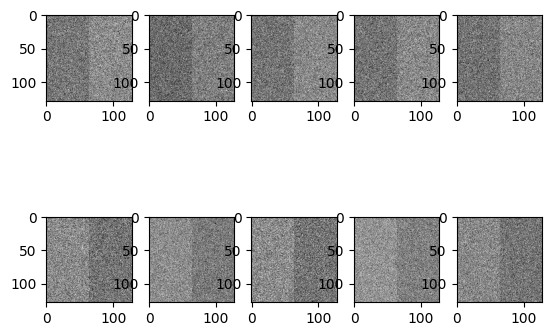

In [35]:
# set toy dataset image configuration
img_sz = 128
num_img_per_cls = 100
num_cls = 2
num_imgs = num_img_per_cls*num_cls
# 128x128 크기의 이미지가 저장될 0으로 구성된 배열 생성
db_imgs = np.zeros((num_imgs,img_sz,img_sz)) 

# 이미지의 중간 열 인덱스 -> 클래스간의 구분을 위해 사용
mid_idx = int(img_sz/num_cls)
# class 0: black/white - # 흑/백 밝기를 갖는 영상 생성
db_imgs[:num_img_per_cls,:,mid_idx:] = 1
# class 1: white/black - # 백/흑 밝기를 갖는 영상 생성
db_imgs[num_img_per_cls:2*num_img_per_cls, :, :mid_idx] = 1

# add noise with normal distribution
noise_w = 1.5 # 노이즈의 표준편차
db_imgs = db_imgs + noise_w*np.random.randn(num_cls*num_img_per_cls,img_sz,img_sz)

# visualize sample images
f, axarr = plt.subplots(2,5) 
for i in range(5):
    axarr[0,i].imshow(db_imgs[i,:,:],cmap='gray')
    axarr[1,i].imshow(db_imgs[num_img_per_cls+i,:,:],cmap='gray')
plt.show()

# pre-process sample images
# flatten each image to 1D vector
# 총영상개수x128x128 영상 배열을 총영상개수x128^2 배열로 규격 변경
db_data = db_imgs.reshape(num_imgs, -1)

# subtract mean
data_mean = np.mean(db_data)
db_data = db_data - data_mean # 이미지 데이터의 평균값을 빼주어 데이터를 중앙에 정렬

# class label 생성
db_labels = np.zeros((num_cls*num_img_per_cls),dtype='int8')
db_labels[:num_img_per_cls] = 0
db_labels[num_img_per_cls:2*num_img_per_cls] = 1


##### 문제2: Toy dataset - training/test 분할

다음 코드에서는 이전 문제에서 생성한 영상 DB를 임의로 학습용 training 데이터와 실험용 test 데이터로 분할한다.

In [36]:
# 
idxs = np.arange(num_img_per_cls) # array of sorted index numbers -> 이미지를 임의로 섞기 위한 인덱스로 사용
np.random.shuffle(idxs) # random shuffle -> 무작위로 섞어서 이미지의 순서를 랜덤하게 만듬
tr_ratio = 0.2 # training data 비율

num_tr_data = int(num_img_per_cls*tr_ratio) # train data의 총 갯수
tr_data = np.zeros((num_tr_data*num_cls,img_sz*img_sz)) # tr_data는 train data의 수만큼의 행을 갖고, 각 행은 이미지 데이터를 표현하는 1D vec로 구성

# class 0과 class 1 각각에 속하는 이미지 데이터를 idxs를 사용하여 무작위로 선택하여 train data 확보
tr_data[:num_tr_data,:] = db_data[idxs[:num_tr_data],:] # class 0 학습 data 확보
tr_data[num_tr_data:2*num_tr_data,:] = db_data[num_img_per_cls+idxs[:num_tr_data],:] # class 0 학습 data 확보

tr_labels = np.zeros((num_tr_data*num_cls),dtype='int8')
# 학습용 레이블 데이터 확보
tr_labels[:num_tr_data] = db_labels[idxs[:num_tr_data]]
tr_labels[num_tr_data:2*num_tr_data] = db_labels[num_img_per_cls+idxs[:num_tr_data]]

num_te_data = num_img_per_cls-num_tr_data # test data의 수는 train data를 제외한 나머지 데이터의 갯수
te_data = np.zeros((num_te_data*num_cls,img_sz*img_sz))
# 테스트용 영상 데이터 확보
te_data[:num_te_data,:] = db_data[idxs[:num_te_data],:]
te_data[num_te_data:2*num_te_data,:] = db_data[num_img_per_cls+idxs[:num_te_data],:]

te_labels = np.zeros((num_te_data*num_cls),dtype='int8')
te_labels[:num_te_data] = db_labels[idxs[num_tr_data:num_img_per_cls]]
te_labels[num_te_data:2*num_te_data] = db_labels[num_img_per_cls+idxs[num_tr_data:num_img_per_cls]]

# print(tr_data.shape)

##### 문제3: Linear classifier 모델의 local gradient 연산 정의

다음 코드는 linear classifier의 객체를 정의하는 class의 코드이다.

In [37]:
class LinearClassifier:
    def __init__(self, data_dim, num_cls):
        self.data_dim = data_dim # 데이터의 차원
        self.num_cls = num_cls # 클래스 수
        # data_dim <- D in slides, num_cls <- M in slides
        self.W = 0.001 * np.random.randn(data_dim, num_cls)
        self.b = np.random.randint(num_cls)
        self.scores = np.zeros(num_cls) # class의 수만큼 score를 저장하는 배열
        self.data = 0
        self.num_data = 0
    def forward(self, data):
        self.data = data
        self.scores = np.dot(data, self.W) + self.b # data차원 : NxD, W차원 : DxM
        # data dimension is N x D
        return self.scores
    def backward(self, upstream_grad):
        # upstream_grad dimensions should be N x M
        # W dimension is D x M
        grad_W = np.dot(self.data.T, upstream_grad) # data차원 : NxD, upstream_grad차원 : NxM -> data전치하여 연산
        # b dimension is 1 x M
        grad_b = np.sum(upstream_grad, axis=0) # upstream_grad의 열 방향 합을 계산     
        grad = {'W':grad_W, 
                'b':grad_b}
        return grad
    def grad_descent(self, grad, lr):
        grad_W = grad['W']
        grad_b = grad['b']
        self.W = self.W - lr*grad_W
        self.b = self.b - lr*grad_b
    def visualize_weights(self):
        f, axarr = plt.subplots(self.num_cls)
        ddim_sq = int(np.sqrt(self.W.shape[0]))
        for j in range(num_cls):
            axarr[j].imshow(self.W[:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()


##### 문제4: Softmax loss 함수의 local gradient 연산 정의

다음 코드는 Softmax 함수 기반의 cross-entropy loss 함수와 이를 기준으로 모델을 학습하는데 필요한 gradient를 계산하는 과정을 포함한다.

In [38]:
class SoftMaxLoss:
    def __init__(self, model, num_cls):
        # set model object
        self.model = model
        self.model_scores = 0
        self.softmax_probs = 0
        self.loss = 0
        self.labels = 0
        self.data = 0
        self.probs = 0
        self.num_cls = num_cls
    def compute_probs(self, data):
        scores = self.model.forward(data)
        self.model_scores = scores
        # compute softmax function
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        softmax_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        self.probs = softmax_probs
        
        return self.probs    
    def compute_loss(self, data, labels):
        self.data = data
        self.compute_probs(data)
        
        num_samples = data.shape[0]
        correct_class_prob = self.probs[np.arange(num_samples), labels]
        loss = -np.log(correct_class_prob).sum() / num_samples
        self.loss = loss
        
        return self.loss
    def compute_grad(self, labels):
        # score dimensions should be N x M
        z = self.probs
        # grad_z dimensions should also be N x M
        grad_z = z - make_labels_onehot(self.labels,self.num_cls)
    
        return self.model.backward(grad_z)


##### 문제5: Gradient descent 알고리즘 구현

다음 코드는 gradient descent 알고리즘으로 학습 데이터에 대해 linear classifier를 학습하는 코드이다.

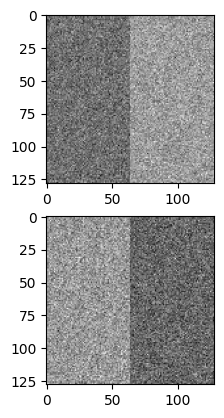

In [39]:
def get_mini_batch(batch_sz, db_data, db_labels, num_data):
    num_samples = db_data.shape[0]
    idxs = np.arange(num_samples)
    np.random.shuffle(idxs)  # 데이터 인덱스를 무작위로 섞음

    batch_data = db_data[idxs[:batch_sz]]  # 미니 배치 데이터 추출
    batch_labels = db_labels[idxs[:batch_sz]]  # 미니 배치 레이블 추출

    # VisualizeBatchData(batch_data,batch_sz)
    return batch_data, batch_labels

def train_linear_classifier(db_data, db_labels, num_cls, lr, batch_sz, num_iter):
    # define & initialize linear classifier
    num_data = db_data.shape[0]
    data_dim = db_data.shape[1]
    model = LinearClassifier(data_dim, num_cls)
    # define loss function
    loss_fn = SoftMaxLoss(model,num_cls)
    # iterative stochastic gradient descent
    for i in range(num_iter):
        # sample data mini-batch
        batch_data, batch_labels = get_mini_batch(batch_sz, db_data, db_labels, num_data)
        model.data = batch_data
        loss_fn.labels = batch_labels
        # compute loss value
        loss = loss_fn.compute_loss(batch_data, batch_labels)
        # print('loss=',loss)
        # compute gradient (backpropagation)
        grad = loss_fn.compute_grad(batch_labels)
        # update model parameters using gradient
        model.grad_descent(grad, lr)
       # if i == 1 :
       #     model.visualize_weights()
       # 1epoch 후에 파라미터를 시각화
    model.visualize_weights()
    return model

lr = 0.001
batch_sz = 8
num_iter = 100
model = train_linear_classifier(tr_data, tr_labels, num_cls, lr, batch_sz, num_iter)

##### 문제6: 학습된 모델을 이용한 test data classification

다음 코드에서는 학습된 linear classifier를 이용하여 테스트 데이터의 판별 결과를 도출한다.

In [40]:
te_scores = model.forward(te_data)
# 판별 결과를 클래스로 변환 (가장 높은 점수를 갖는 클래스 선택)
te_predictions = np.argmax(te_scores, axis=1)

# 정확도 계산
# 예측값과 실제 레이블이 일치하는 경우 True
correct_predictions = (te_predictions == te_labels) 
# 정확한 예측의 비율 계산 
Acc = np.mean(correct_predictions.astype(float))  

print('Classification accuracy= {}%'.format(Acc*100))

Classification accuracy= 100.0%


***

##### 문제7: 더 어려운 3 class toy 데이터 생성하여 위 과정 반복 후 결과 정리

아래 전체 과정 중 1번 항목을 자체적으로 구현하고, 이후의 부분은 위의 코드를 활용하여 결과를 도출하는 것을 목표로 한다. 
[1]. Data 생성+처리: Toy DB 생성, 전처리, training/test 분할 <- 이 부분에서 3가지 클래스로 구성되는 간단한 영상 DB을 생성하는 코딩 수행
2. Linear classifier 모델 정의 및 관련 연산
3. Gradient descent 알고리즘 및 Linear classifier 모델의 parameter에 대한 gradient 연산
4. 학습된 linear classifier 모델 parameter를 적용하여 test data의 classification 결과 도출


## 1. 3 class toy dataset 생성

- 흑/백, 백/흑 밝기의 영상을 통해 2 class toy dataset을 생성하였습니다.
- 3 class dataset은 다양하지만 과제에서 사용했던 toy dataset을 확장시켜 3 class toy dataset으로 이용할 것입니다.
    - 백/흑/흑 : class 0
    - 흑/백/흑 : class 1
    - 흑/흑/백 : class 2
- 위처럼 toy data의 class를 분류하여 2 class toy data와 같은 과정을 통해 classification결과를 도출해보겠습니다.

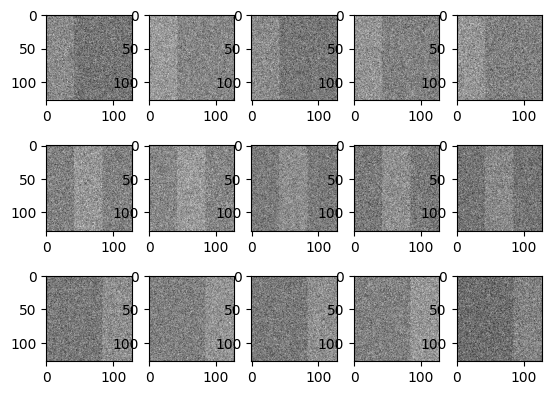

In [41]:
# 데이터셋 구성
img_sz = 128
num_img_per_cls = 100
num_cls = 3  # 클래스 수를 3으로 설정
num_imgs = num_img_per_cls * num_cls
db_imgs = np.zeros((num_imgs, img_sz, img_sz), dtype='float64')

# 이미지 중간 열 인덱스
mid_idx = int(img_sz / num_cls)

# 클래스 0: 백/흑/흑
db_imgs[:num_img_per_cls, :, :mid_idx] = 1
# 클래스 1: 흑/백/흑
db_imgs[num_img_per_cls:2*num_img_per_cls, :, mid_idx:2*mid_idx] = 1
# 클래스 2: 흑/흑/백
db_imgs[2*num_img_per_cls:, :, 2*mid_idx:] = 1

# 노이즈 추가
noise_w = 1.5
db_imgs = db_imgs + noise_w * np.random.randn(num_imgs, img_sz, img_sz)

# 이미지 시각화
f, axarr = plt.subplots(num_cls, 5)
for i in range(num_cls):
    for j in range(5):
        axarr[i, j].imshow(db_imgs[i * num_img_per_cls + j, :, :], cmap='gray')

plt.show()

# 데이터 전처리
db_data = db_imgs.reshape(num_imgs, -1)
data_mean = np.mean(db_data)
db_data = db_data - data_mean

db_labels = np.zeros((num_cls * num_img_per_cls), dtype='int8')
db_labels[:num_img_per_cls] = 0
db_labels[num_img_per_cls:2 * num_img_per_cls] = 1
db_labels[2 * num_img_per_cls:] = 2


## 2. toy dataset train/test 분할

In [42]:
# 이미지 데이터와 레이블을 통합한 데이터셋 만들기
num_img_per_cls = 100
num_cls = 3
img_sz = 128

# 클래스 0, 1, 2에 해당하는 이미지 생성 및 노이즈 추가
# 이미지 생성 및 노이즈 추가 부분은 이전 코드와 동일하게 사용

# 인덱스 생성 및 무작위 섞기
idxs = np.arange(num_img_per_cls)
np.random.shuffle(idxs)

# 훈련 데이터 비율
tr_ratio = 0.2

# 훈련 데이터와 테스트 데이터 개수 계산
num_tr_data = int(num_img_per_cls * tr_ratio)
num_te_data = num_img_per_cls - num_tr_data

# 훈련 데이터 배열 초기화
tr_data = np.zeros((num_tr_data * num_cls, img_sz * img_sz))

# 훈련 데이터 생성
for i in range(num_cls):
    tr_data[i * num_tr_data:(i + 1) * num_tr_data, :] = db_data[i * num_img_per_cls + idxs[:num_tr_data], :]
# 훈련 데이터 레이블 초기화
tr_labels = np.zeros((num_tr_data * num_cls), dtype='int8')
# 훈련 데이터 레이블 생성
for i in range(num_cls):
    tr_labels[i * num_tr_data:(i + 1) * num_tr_data] = db_labels[i * num_img_per_cls + idxs[:num_tr_data]]

# 테스트 데이터 배열 초기화
te_data = np.zeros((num_te_data * num_cls, img_sz * img_sz))

# 테스트 데이터 생성
for i in range(num_cls):
    te_data[i * num_te_data:(i + 1) * num_te_data, :] = db_data[i * num_img_per_cls + idxs[num_tr_data:num_img_per_cls], :]
# 테스트 데이터 레이블 초기화
te_labels = np.zeros((num_te_data * num_cls), dtype='int8')
# 테스트 데이터 레이블 생성
for i in range(num_cls):
    te_labels[i * num_te_data:(i + 1) * num_te_data] = db_labels[i * num_img_per_cls + idxs[num_tr_data:num_img_per_cls]]


## 3. Linear Classifier 모델

In [43]:
class LinearClassifier:
    def __init__(self, data_dim, num_cls):
        self.data_dim = data_dim # 데이터의 차원
        self.num_cls = num_cls # 클래스 수
        # data_dim <- D in slides, num_cls <- M in slides
        self.W = 0.001 * np.random.randn(data_dim, num_cls)
        self.b = np.random.randint(num_cls)
        self.scores = np.zeros(num_cls) # class의 수만큼 score를 저장하는 배열
        self.data = 0
        self.num_data = 0
    def forward(self, data):
        self.data = data
        self.scores = np.dot(data, self.W) + self.b # data차원 : NxD, W차원 : DxM
        # data dimension is N x D
        return self.scores
    def backward(self, upstream_grad):
        # upstream_grad dimensions should be N x M
        # W dimension is D x M
        grad_W = np.dot(self.data.T, upstream_grad) # data차원 : NxD, upstream_grad차원 : NxM -> data전치하여 연산
        # b dimension is 1 x M
        grad_b = np.sum(upstream_grad, axis=0) # upstream_grad의 열 방향 합을 계산     
        grad = {'W':grad_W, 
                'b':grad_b}
        return grad
    def grad_descent(self, grad, lr):
        grad_W = grad['W']
        grad_b = grad['b']
        self.W = self.W - lr*grad_W
        self.b = self.b - lr*grad_b
    def visualize_weights(self):
        f, axarr = plt.subplots(self.num_cls)
        ddim_sq = int(np.sqrt(self.W.shape[0]))
        for j in range(num_cls):
            axarr[j].imshow(self.W[:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()


## 4. Softmax 함수

In [44]:
class SoftMaxLoss:
    def __init__(self, model, num_cls):
        # set model object
        self.model = model
        self.model_scores = 0
        self.softmax_probs = 0
        self.loss = 0
        self.labels = 0
        self.data = 0
        self.probs = 0
        self.num_cls = num_cls
    def compute_probs(self, data):
        scores = self.model.forward(data)
        self.model_scores = scores
        # compute softmax function
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        softmax_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        self.probs = softmax_probs
        
        return self.probs    
    def compute_loss(self, data, labels):
        self.data = data
        self.compute_probs(data)
        
        num_samples = data.shape[0]
        correct_class_prob = self.probs[np.arange(num_samples), labels]
        loss = -np.log(correct_class_prob).sum() / num_samples
        self.loss = loss
        
        return self.loss
    def compute_grad(self, labels):
        # score dimensions should be N x M
        z = self.probs
        # grad_z dimensions should also be N x M
        grad_z = z - make_labels_onehot(self.labels,self.num_cls)
        return self.model.backward(grad_z)


## 5. 모델 학습

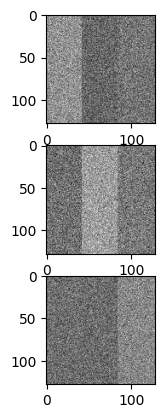

In [45]:
def get_mini_batch(batch_sz, db_data, db_labels, num_data):
    num_samples = db_data.shape[0]
    idxs = np.arange(num_samples)
    np.random.shuffle(idxs)  # 데이터 인덱스를 무작위로 섞음

    batch_data = db_data[idxs[:batch_sz]]  # 미니 배치 데이터 추출
    batch_labels = db_labels[idxs[:batch_sz]]  # 미니 배치 레이블 추출

    # VisualizeBatchData(batch_data,batch_sz)
    return batch_data, batch_labels

def train_linear_classifier(db_data, db_labels, num_cls, lr, batch_sz, num_iter):
    # define & initialize linear classifier
    num_data = db_data.shape[0]
    data_dim = db_data.shape[1]
    model = LinearClassifier(data_dim, num_cls)
    # define loss function
    loss_fn = SoftMaxLoss(model,num_cls)
    # iterative stochastic gradient descent
    for i in range(num_iter):
        # sample data mini-batch
        batch_data, batch_labels = get_mini_batch(batch_sz, db_data, db_labels, num_data)
        model.data = batch_data
        loss_fn.labels = batch_labels
        # compute loss value
        loss = loss_fn.compute_loss(batch_data, batch_labels)
        # print('loss=',loss)
        # compute gradient (backpropagation)
        grad = loss_fn.compute_grad(batch_labels)
        # update model parameters using gradient
        model.grad_descent(grad, lr)
    model.visualize_weights()
    return model

lr = 0.001
batch_sz = 8
num_iter = 100
model = train_linear_classifier(tr_data, tr_labels, num_cls, lr, batch_sz, num_iter)

## 6. 모델 성능 평가

In [46]:
te_scores = model.forward(te_data)
# 판별 결과를 클래스로 변환 (가장 높은 점수를 갖는 클래스 선택)
te_predictions = np.argmax(te_scores, axis=1)

# 정확도 계산
# 예측값과 실제 레이블이 일치하는 경우 True
correct_predictions = (te_predictions == te_labels) 
# 정확한 예측의 비율 계산 
Acc = np.mean(correct_predictions.astype(float))  

print('Classification accuracy= {}%'.format(Acc*100))

Classification accuracy= 100.0%
